In [15]:
from google.colab import drive
import os, pathlib
from pathlib import Path
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
drive.mount('/content/drive')

REPO_URL   = "https://github.com/Svanzi/Tennis-Shot-Recognition.git"
BASE       = "/content/drive/MyDrive/University/Deep"
SPARSE_DIR = "Tennis-Shot-Recognition"   # repo "leggera" solo per i dati
TARGET     = f"{BASE}/{SPARSE_DIR}"

os.makedirs(BASE, exist_ok=True)

# Clona in modalità sparse solo la prima volta
if not os.path.exists(TARGET):
    %cd {BASE}
    !git clone --filter=blob:none --sparse {REPO_URL} {SPARSE_DIR}
    %cd {SPARSE_DIR}
    !git sparse-checkout set DataSet
else:
    %cd {TARGET}
    !git pull

# Path da usare nel notebook
from pathlib import Path
DATA_DIR = Path(TARGET) / "DataSet"
print("DATA_DIR =", DATA_DIR)

Mounted at /content/drive
/content/drive/MyDrive/University/Deep/Tennis-Shot-Recognition
Already up to date.
DATA_DIR = /content/drive/MyDrive/University/Deep/Tennis-Shot-Recognition/DataSet


In [13]:
DATA_DIR = Path("/content/drive/MyDrive/University/Deep/Tennis-Shot-Recognition/DataSet")
players = sorted([p for p in DATA_DIR.iterdir() if p.is_dir()])

X=[]
Y=[]
x_test=[]
y_test=[]

for player in tqdm(players, desc="Players", leave=False):
    print(f"\n**** Parsing the shots of {player.name} ****\n")
    for shot_csv in sorted(player.glob("*.csv")):
        print(shot_csv.name)
        data = pd.read_csv(shot_csv)

        data_train = data[:int(0.8*len(data))]
        data_test = data[int(0.8*len(data)):]

        features_train = list(data_train.loc[:, data.columns != 'shot'].to_numpy())
        features_test = list(data_test.loc[:, data.columns != 'shot'].to_numpy())

        X.extend(features_train)
        Y.extend(data_train["shot"].to_numpy().flatten())

        x_test.extend(features_test)
        y_test.extend(data_test["shot"].to_numpy().flatten())

X = np.stack(X, axis=0)
X = np.array(X)
Y = np.array(Y)
y_test = np.array(y_test)

print("\n\n")
print(f"Loaded {len(Y)} shots for training")
print(f"Loaded {len(y_test)} shots for test")

Players:   0%|          | 0/2 [00:00<?, ?it/s]


**** Parsing the shots of Alcaraz ****

backhand_001.csv
backhand_002.csv
backhand_003.csv
backhand_004.csv
backhand_005.csv
backhand_006.csv
backhand_007.csv
forehand_001.csv
forehand_002.csv
forehand_003.csv
forehand_004.csv
forehand_005.csv
forehand_006.csv
forehand_007.csv
forehand_008.csv
forehand_009.csv
forehand_010.csv
forehand_011.csv
forehand_012.csv
forehand_013.csv
forehand_014.csv
forehand_015.csv
forehand_016.csv
forehand_017.csv
forehand_018.csv
forehand_019.csv
forehand_020.csv
forehand_021.csv
forehand_022.csv
forehand_023.csv
forehand_024.csv
forehand_025.csv
forehand_026.csv
forehand_027.csv
forehand_028.csv
forehand_029.csv
forehand_030.csv
neutral_001.csv
neutral_002.csv
neutral_003.csv
neutral_004.csv
neutral_005.csv
neutral_006.csv
neutral_007.csv
neutral_008.csv
neutral_009.csv
neutral_010.csv
neutral_011.csv
neutral_012.csv
neutral_013.csv
neutral_014.csv
neutral_015.csv
neutral_016.csv
neutral_017.csv
neutral_018.csv
neutral_019.csv
neutral_020.csv
neutral_02

[np.str_('neutral'), np.str_('backhand'), np.str_('forehand')] [1656, 360, 1344]


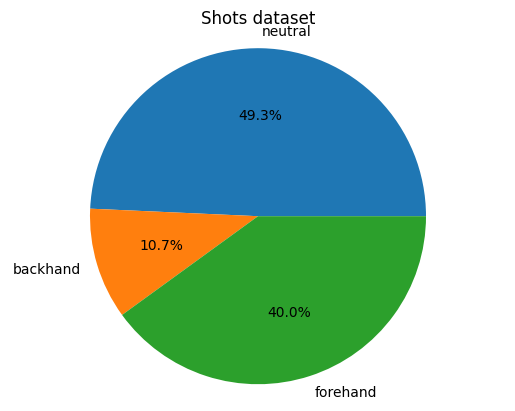

In [17]:
shots = list(set(Y))
occurences = [np.count_nonzero(Y == shot) for shot in shots]
#print(shots, occurences)

fig, ax = plt.subplots()
ax.pie(occurences, labels=shots, autopct='%1.1f%%')
ax.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
ax.set_title('Shots dataset')


plt.show()